
**Свёрточные нейронные сети (СНС)**

Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

Библиотеки: [Python, Tensorflow]


In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.9.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: kapre


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
#загрузим и подготовим датасет

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = np.squeeze(train_y.astype(np.int32))
test_y = np.squeeze(test_y.astype(np.int32))

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


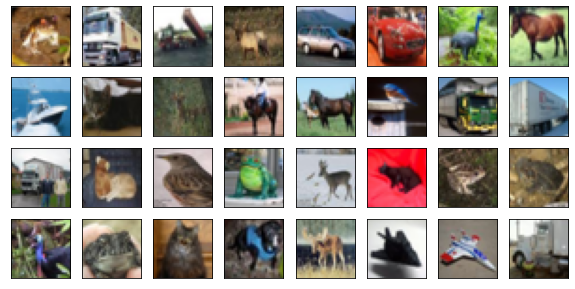

In [4]:
#визуализируем

some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 5))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
#пайплайн

NUM_EPOCHS = 10
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [6]:
#модель CNN

class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

In [7]:
#функции потерь и вычисления точности


def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [8]:
#подготовка к обучению

LEARNING_RATE = 0.0007

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
writer = tf.summary.create_file_writer('logs/adam')

In [9]:
%%time

#обучаем модель
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy: 13.28 %
[ 200] Accuracy: 40.62 %
[ 400] Accuracy: 53.52 %
[ 600] Accuracy: 58.98 %
[ 800] Accuracy: 59.38 %
[1000] Accuracy: 62.50 %
[1200] Accuracy: 63.28 %
[1400] Accuracy: 60.16 %
[1600] Accuracy: 64.06 %
[1800] Accuracy: 65.62 %
[2000] Accuracy: 67.19 %
[2200] Accuracy: 67.19 %
[2400] Accuracy: 69.14 %
[2600] Accuracy: 69.92 %
[2800] Accuracy: 67.97 %
[3000] Accuracy: 62.11 %
[3200] Accuracy: 69.92 %
[3400] Accuracy: 67.97 %
[3600] Accuracy: 70.70 %
[3800] Accuracy: 70.70 %
[4000] Accuracy: 69.92 %
[4200] Accuracy: 71.48 %
[4400] Accuracy: 70.31 %
[4600] Accuracy: 68.75 %
[4800] Accuracy: 71.88 %
[5000] Accuracy: 73.83 %
[5200] Accuracy: 74.61 %
[5400] Accuracy: 73.05 %
[5600] Accuracy: 70.31 %
[5800] Accuracy: 69.92 %
[6000] Accuracy: 70.31 %
[6200] Accuracy: 72.27 %
[6400] Accuracy: 73.05 %
[6600] Accuracy: 69.92 %
[6800] Accuracy: 73.05 %
[7000] Accuracy: 71.48 %
[7200] Accuracy: 69.53 %
[7400] Accuracy: 73.83 %
[7600] Accuracy: 67.97 %
[7800] Accuracy: 72.27 %


In [10]:
%%time

#оценка качества

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 72.65 %
CPU times: user 1.38 s, sys: 137 ms, total: 1.51 s
Wall time: 1.51 s


In [11]:
# интерференс и отображение результата

def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

In [16]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

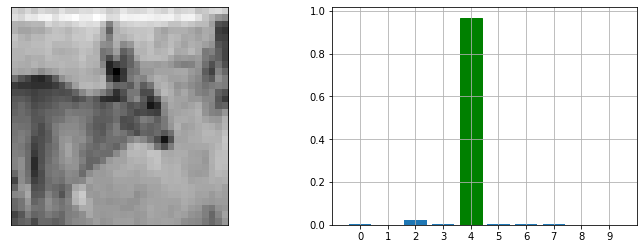

Predicted: 4
True Answer: 4 - deer


In [18]:
# предсказание и проверка

import random
idx = random.randint(1, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {}'.format(test_y[idx]) + ' - ' + classes[int(test_y[idx])])